In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import scipy.io as scio
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import os
import torch.utils.data as data
import random
import shutil
import glob
import csv
import math
import pandas
import cv2
from matplotlib import pyplot as plt
import torch.nn.functional as F



In [2]:
dst_dir = '/home/sjtu/gcj/data/depth_data/depth_26class'
EXTENSIONS = ['.mat']
def mat_read(filepath):
    dataFile = filepath
    data = scio.loadmat(dataFile)
    #读取mat里的depth数据
    depth = data['depth']
    #归一化
    depth=depth*25
    depth=depth.astype(np.int)
    depth=depth.astype(np.float)
    depth_scale=depth[depth>0]
    avrg=np.mean(depth_scale)
    var=np.std(depth_scale)
    index=depth==0
    depth[index]=avrg
    depth_scale=(depth-avrg)/var
    ##TODO
    #where_are_nan = np.isnan(depth)
    #depth[where_are_nan] = 0
    #变成三通道
    #depth3=[]
    #for i in range(3):
    #   depth3.append(depth_scale)
    depth3=np.array(depth_scale)
    #加模糊
    #depth3=cv2.GaussianBlur(depth3,(5,5),1.5)
    #depth3=cv2.medianBlur(depth3,5)
    #kernel = np.ones((5,5),np.float32)/25
    #depth3 = cv2.filter2D(depth3,-1,kernel)
    #depth3=cv2.blur(depth3,(3,5))
    #create tensor from numpy.ndarray
    depth=torch.from_numpy(depth3)
    depth=depth.type(torch.FloatTensor)
    return depth

def is_mat_file(filename):
    return any(filename.endswith(extension) for extension in EXTENSIONS)

#类名
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    classes.sort()
    class_to_idx = {classes[i]:i for i in range(len(classes))}
    return classes,class_to_idx

#input: dir+train(or val)+class
#output: 数据文件的集合
def make_dataset(dir,phase,class_to_idx):
    datas = []
    dir = os.path.join(dir,phase)
    for target in os.listdir(dir):
        d = os.path.join(dir,target)
        if not os.path.isdir(d):
            continue
        
        for root, _, fnames in sorted(os.walk(d)):
            for fname in fnames:
                if is_mat_file(fname):
                    path = os.path.join(root,fname)
                    item = (path,class_to_idx[target])
                    datas.append(item)
    return datas

class ViewpointDataset(data.Dataset):
    def __init__(self, root, transform = None, phase = None):
        dir = os.path.join(root, phase)
        classes, class_to_idx = find_classes(dir)
        datas = make_dataset(root,phase, class_to_idx)
        if len(datas) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported extensions are: " + ",".join(EXTENSIONS)))
        self.root = root
        self.datas = datas
        self.phase = phase
        self.classes = classes
        #todo
        self.width = 480
        self.height = 640
        self.suffix = '.mat'
        self.transform = transform
        
    #深度矩阵转成tensor  
    def __getitem__(self, idx):
        mat_path, label = self.datas[idx]
        #preprocess
        depth_tensor = mat_read(mat_path)            
        
        #numpy转成tensor  (不用了，matread里边转过tensor了)
        #depth_tensor = torch.from_numpy(depth)
        return depth_tensor, label
    
    def __len__(self):
        return len(self.datas)
#建立数据集
transform=transforms.Compose([transforms.RandomCrop([224,224])])
dsets = {x: ViewpointDataset(dst_dir,transform=transform,phase=x) for x in ['train', 'val']}
dset_loaders = {x:torch.utils.data.DataLoader(dsets[x],batch_size=24,shuffle=True, num_workers=8) for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['val'].classes
print(dset_sizes)
print(len(dset_classes))
use_gpu = torch.cuda.is_available()

{'train': 76436, 'val': 32733}
26


In [20]:
#训练所用网络模型：
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(11,11),stride=(4,4),padding=(2,2)) # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        #self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #480*640:5120  300*300:1024
        #self.fc1   = nn.Linear(5120, 120) # an affine operation: y = Wx + b
        self.fc4   = nn.Linear(512, 512) 
        self.fc1   = nn.Linear(512, 256) 
        #self.fc2   = nn.Linear(120, 120) 
        #self.fc2   = nn.Linear(120,84)
        #self.fc2   = nn.Linear(1024, 120)
        self.fc3   = nn.Linear(256, 26)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 4) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 4) # If the size is a square you can only specify a single number
        #x = F.max_pool2d(F.relu(self.conv3(x)), 3) 
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(F.relu(self.conv5(x)), 4) 
        x = x.view(-1, self.num_flat_features(x))
        #'''
        x = F.dropout(x,p=0.7)
        x=F.relu(self.fc4(x))
        x=  F.dropout(x,p=0.6)
        x = F.relu(self.fc1(x))
        x=  F.dropout(x,p=0.4)
        #x=  F.dropout(x,p=0.5)
        #x = F.relu(self.fc2(x))
        #x=  F.dropout(x,p=0.4)
        #x = F.relu(self.fc3(x))
        x=  F.dropout(x,p=0.5)
        x = self.fc3(x)
        #'''
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
model = Net().cuda()
print(model)
'''
a=mat_read('/home/sjtu/gcj/data/depth_data/depth_2class/train/off_32_0_180/95_depth.mat')
depth=torch.from_numpy(a)
a=depth.type(torch.FloatTensor)
c=torch.FloatTensor(1,1,480,640)#需要写成3dtensor 1代表batch
c[0]=a
b=Variable(c.cuda())
print(type(b))
outputs = model(b)
print outputs
#'''

Net (
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc4): Linear (512 -> 512)
  (fc1): Linear (512 -> 256)
  (fc3): Linear (256 -> 26)
)


"\na=mat_read('/home/sjtu/gcj/data/depth_data/depth_2class/train/off_32_0_180/95_depth.mat')\ndepth=torch.from_numpy(a)\na=depth.type(torch.FloatTensor)\nc=torch.FloatTensor(1,1,480,640)#\xe9\x9c\x80\xe8\xa6\x81\xe5\x86\x99\xe6\x88\x903dtensor 1\xe4\xbb\xa3\xe8\xa1\xa8batch\nc[0]=a\nb=Variable(c.cuda())\nprint(type(b))\noutputs = model(b)\nprint outputs\n#"

In [21]:
#def real_data(filepath):
def test(csv_path):
    with open(csv_path) as f:
        l=[]
        lines=csv.reader(f)
        for line in lines:
            l.append(line)
    l.remove(l[0])
    l=np.array(l)
    depth=l[:,1:]
    #print np.shape(depth)

    depth=depth.astype(np.float)

    #depth[:120,:]=0
    #depth[330:,:]=0
    #depth[:,500:]=0
    #depth[:,0:0]=0
    
    depth_scale=depth[depth>0]
    avrg=np.mean(depth_scale)
    var=np.std(depth_scale)
    index=depth==0
    depth[index]=avrg
    depth_scale=(depth-avrg)/var
    
    '''#depth_scale=depth_scale[100:400,200:500]
    depth_scale = depth_scale*100
    depth_scale=depth_scale.astype(np.int)
    depth=depth.astype(np.float)/100
    #depth_scale=cv2.blur(depth_scale,(3,5))
    #depth_scale=cv2.GaussianBlur(depth_scale,(5,5),1.5)
    #depth_scale=cv2.medianBlur(depth_scale,5)
    '''
    #depth_scale = cv2.bilateralFilter(depth_scale,9,75,75)
    depth3=np.expand_dims(depth_scale,0)
    depth3=np.expand_dims(depth3,0)
    #create tensor from numpy.ndarray
    depth=torch.from_numpy(depth3)
    depth=depth.type(torch.FloatTensor)
    return depth,depth_scale

In [22]:
def test_model(modelname,dir_name):
    for root, dirnames, _ in os.walk(dir_name):
        if len(dirnames)!=0:
            count=0
            acc=0
            length = 0
            for dirname in dirnames:
                this_acc = 0
                dname = os.path.join(root, dirname)
                names=glob.glob(dname+r'/*.csv')
                this_length  = len(names)
                #model=torch.load("./model_2class.pth")
                model=torch.load(modelname)
                model.cuda()
                length=len(names)+length
                for f in names:
                    fname = os.path.split(f)[-1]
                    csv_path = os.path.join(dname, fname)
                    inputs,depth_scale=test(csv_path)
                    label=dirname
                    inputs = Variable(inputs.cuda())
                    outputs = model(inputs)
                    #print outputs.data
                    _,preds = torch.max(outputs.data, 1)
                    preds = preds.cpu().numpy()
                    #print preds
                    #preds=[[12]]
                    #plt.imshow(preds)
                    #print dset_classes[preds[0][0]]
                    #plt.figure(count)
                    count=count+1
                    title_name=dset_classes[preds[0][0]].split('_')[2]+'_'+dset_classes[preds[0][0]].split('_')[3]
                    if label==title_name:
                        acc=acc+1
                        this_acc = this_acc+1
                    this_accuracy=float(this_acc)/float(this_length)
                    #print('{}`s Acc: {:.4f}'.format(dirname,this_accuracy))
            accuracy=float(acc)/float(length)
            print('{}`s Acc: {:.4f}'.format(modelname,accuracy))
            #plt.title(str(count)+' '+dset_classes[preds[0][0]])
            #plt.title(title_name)
            #plt.imshow(depth_scale)
    return accuracy,modelname

def visual_best_model(modelname,dir_name):
    for root, dirnames, _ in os.walk(dir_name):
        if len(dirnames)!=0:
            count=0
            acc=0
            length = 0
            for dirname in dirnames:
                this_acc = 0
                dname = os.path.join(root, dirname)
                names=glob.glob(dname+r'/*.csv')
                this_length  = len(names)
                #model=torch.load("./model_2class.pth")
                model=torch.load(modelname)
                model.cuda()
                length=len(names)+length
                for f in names:
                    fname = os.path.split(f)[-1]
                    csv_path = os.path.join(dname, fname)
                    inputs,depth_scale=test(csv_path)
                    label=dirname
                    inputs = Variable(inputs.cuda())
                    outputs = model(inputs)
                    #print outputs.data
                    _,preds = torch.max(outputs.data, 1)
                    preds = preds.cpu().numpy()
                    #print preds
                    #preds=[[12]]
                    #plt.imshow(preds)
                    #print dset_classes[preds[0][0]]
                    plt.figure(count)
                    count=count+1
                    title_name=dset_classes[preds[0][0]].split('_')[2]+'_'+dset_classes[preds[0][0]].split('_')[3]
                    if label==title_name:
                        acc=acc+1
                        this_acc = this_acc+1
                    plt.title(title_name)
                    plt.imshow(depth_scale)
                this_accuracy=float(this_acc)/float(this_length)
                print('{}`s Acc: {:.4f}'.format(dirname,this_accuracy))
            accuracy=float(acc)/float(length)
            print('{}`s Acc: {:.4f}'.format(modelname,accuracy))
            print('total:{}, wrong:{}'.format(length,length-acc))
            #plt.title(str(count)+' '+dset_classes[preds[0][0]])
    return accuracy,modelname


In [23]:
dname='./cropmap'
model_dir = './model'
modelname=glob.glob(model_dir+r'/model_best_*.pth')
modelname = sorted(modelname)
bestacc=0
best_model=None
for model in modelname:
    acc,model=test_model(model,dname)
    if acc>=bestacc:
        best_model = model
        bestacc=acc
print('Best_Acc: {:.4f}'.format(bestacc))
print best_model
#visual_best_model(best_model,dname)

./model/model_best_1.pth`s Acc: 0.7600
./model/model_best_10.pth`s Acc: 0.7467
./model/model_best_2.pth`s Acc: 0.7733
./model/model_best_3.pth`s Acc: 0.7867
./model/model_best_4.pth`s Acc: 0.7733
./model/model_best_5.pth`s Acc: 0.8400
./model/model_best_6.pth`s Acc: 0.7200
./model/model_best_7.pth`s Acc: 0.8267
./model/model_best_8.pth`s Acc: 0.7067
./model/model_best_9.pth`s Acc: 0.7733
Best_Acc: 0.8400
./model/model_best_5.pth


0_180`s Acc: 0.8462
90_0`s Acc: 0.6000
0_0`s Acc: 0.3125
0_270`s Acc: 0.8333
0_90`s Acc: 0.9091
45_0`s Acc: 1.0000
./model/model_26class_7.pth`s Acc: 0.7333
total:75, wrong:20


(0.7333333333333333, './model/model_26class_7.pth')

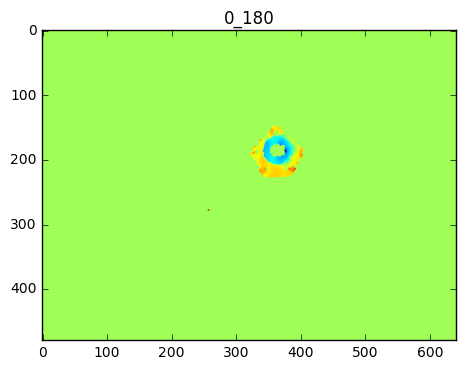

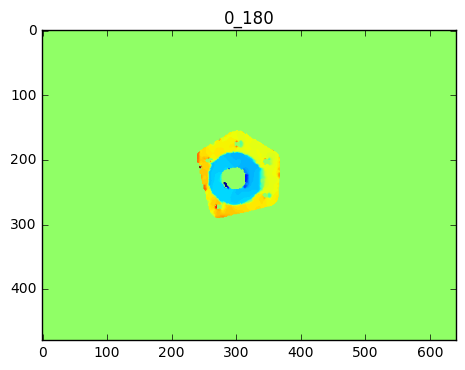

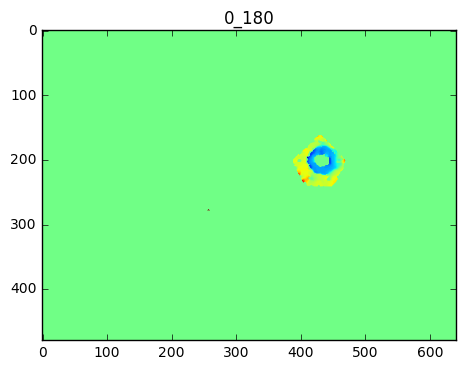

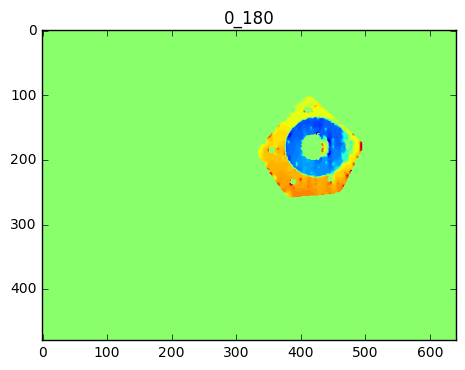

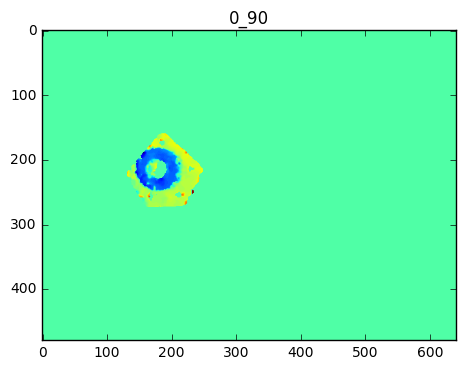

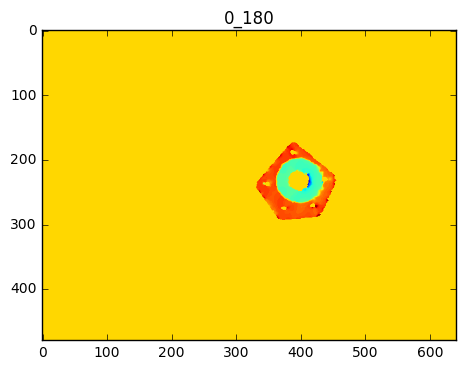

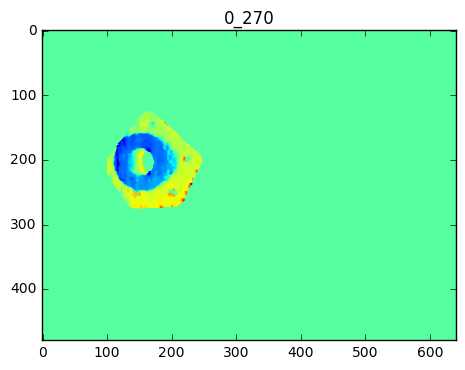

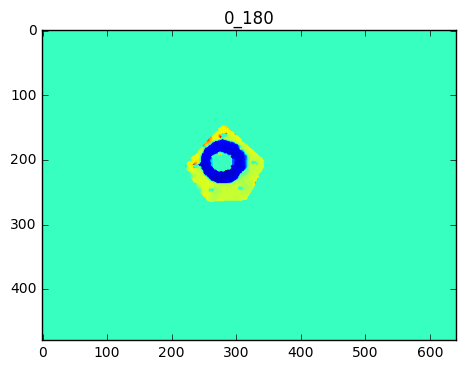

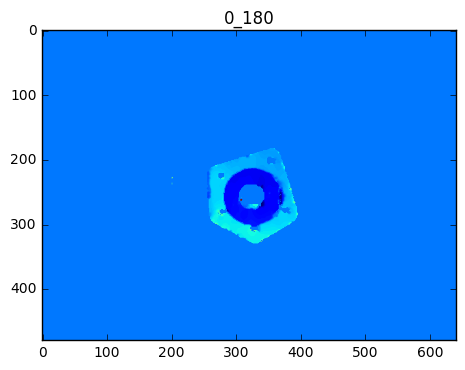

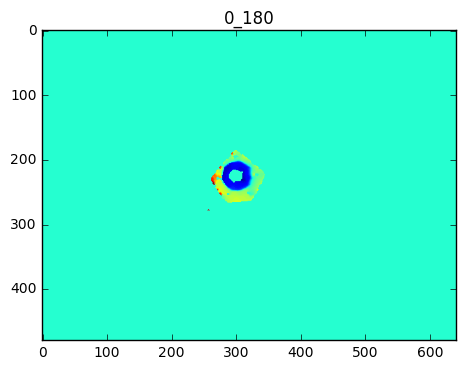

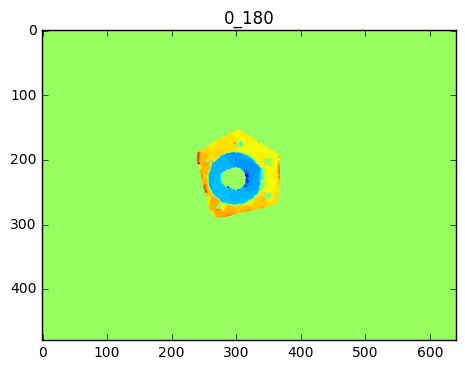

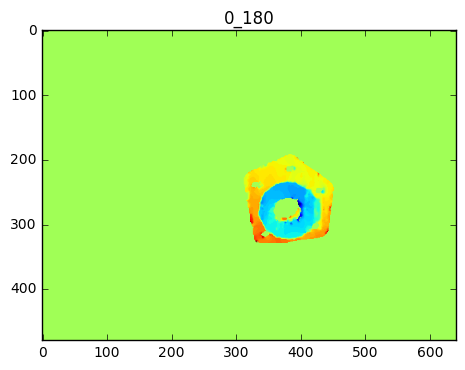

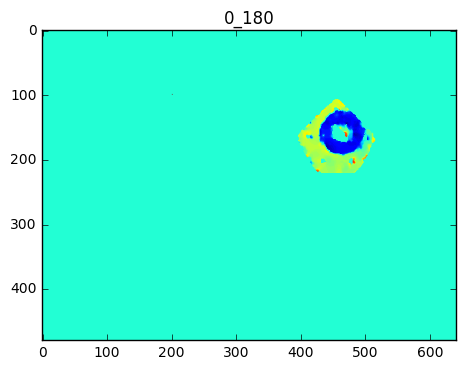

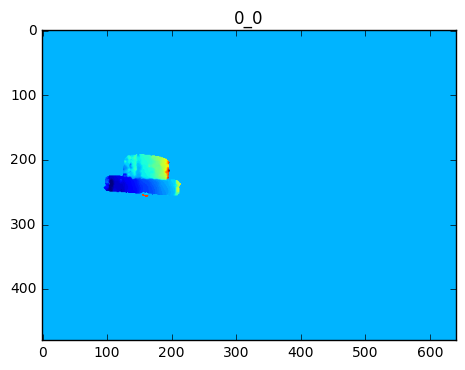

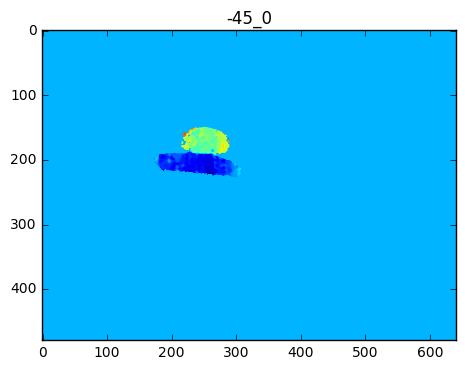

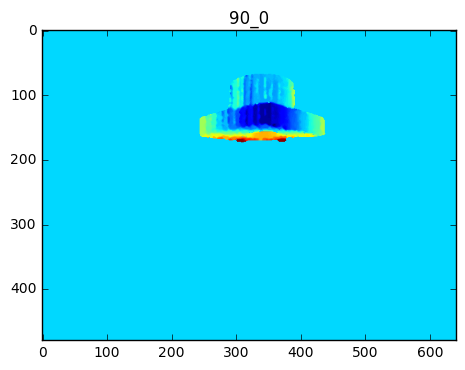

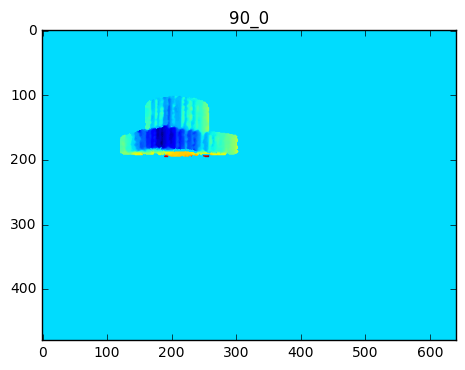

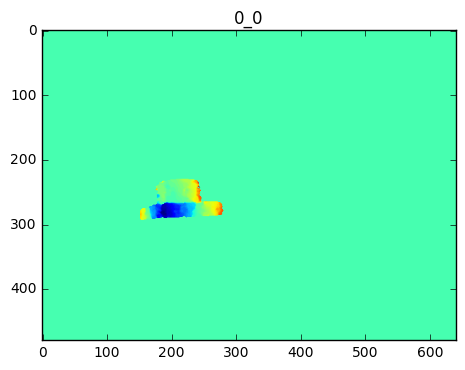

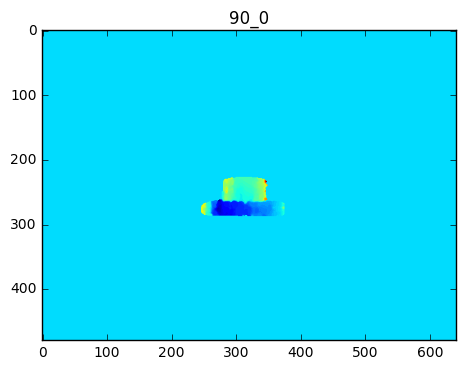

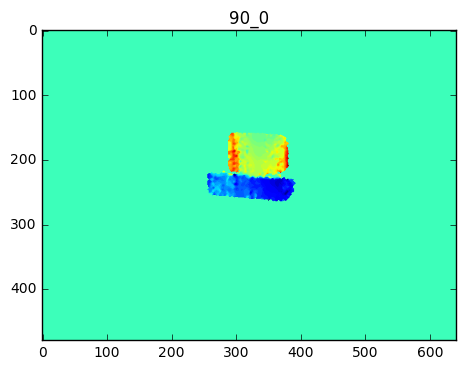

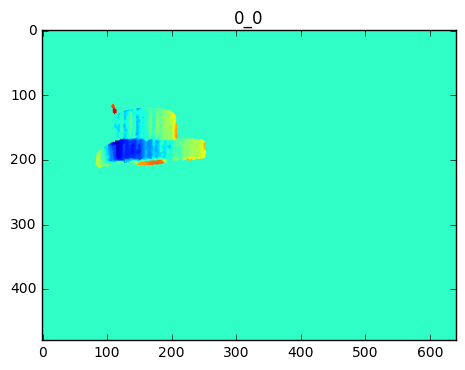

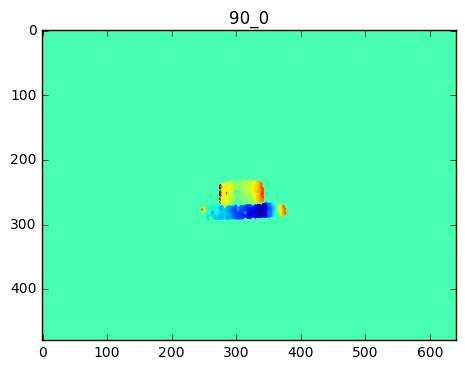

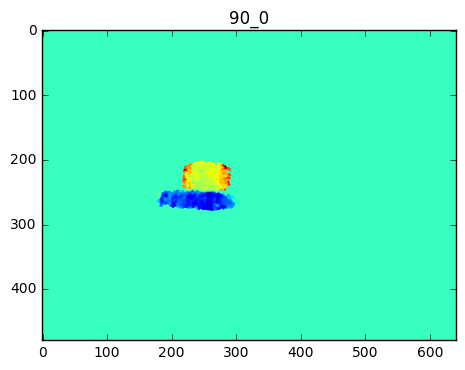

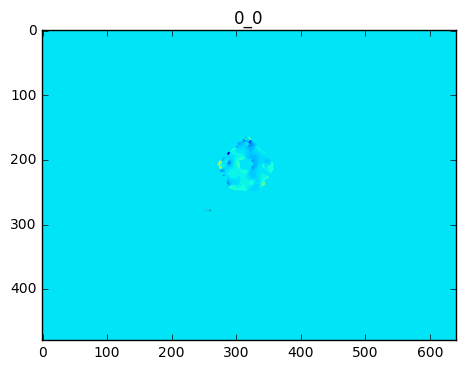

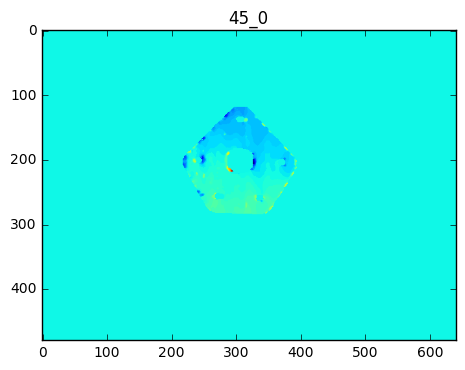

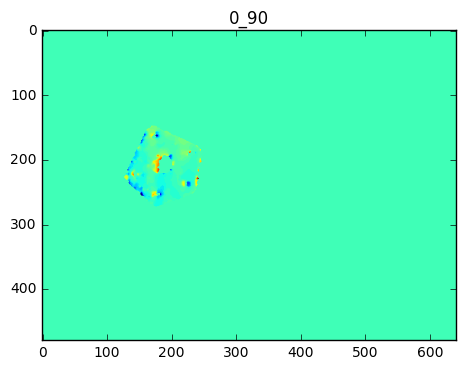

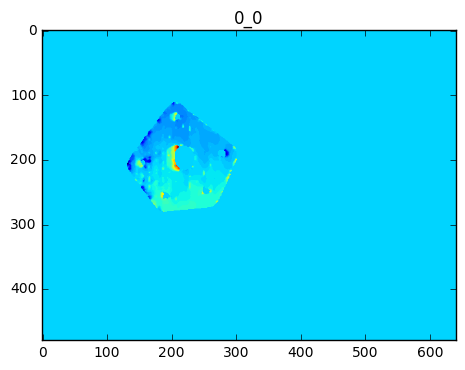

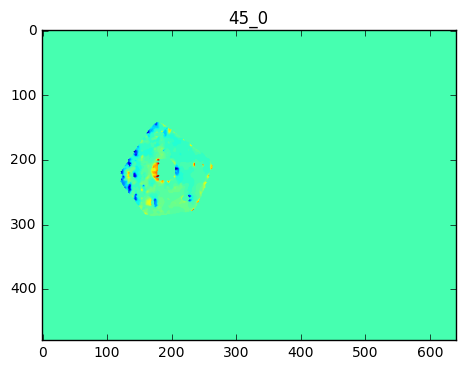

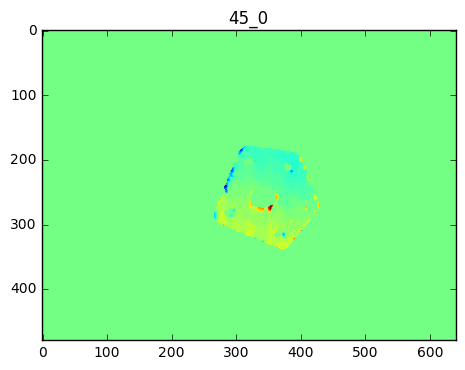

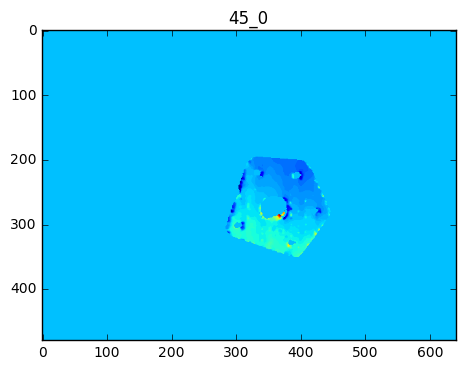

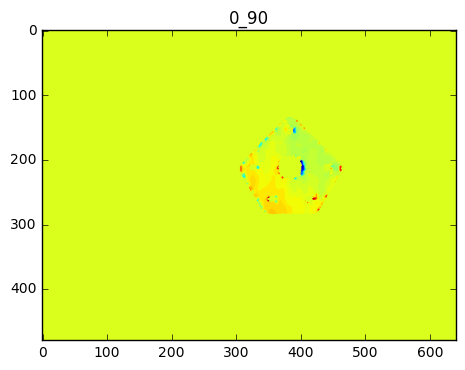

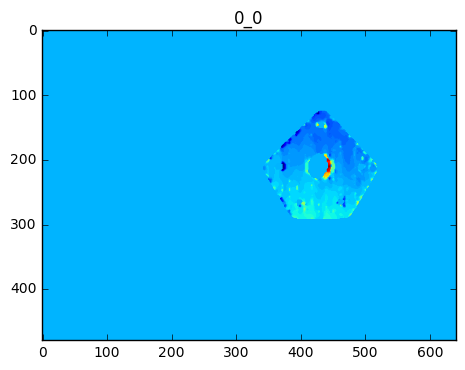

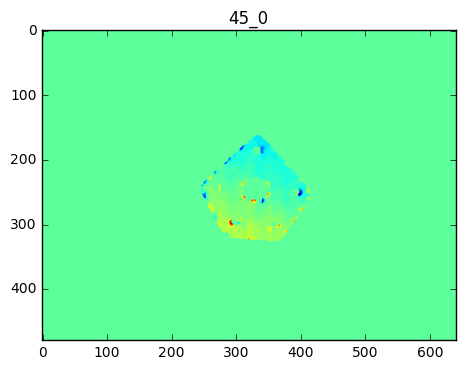

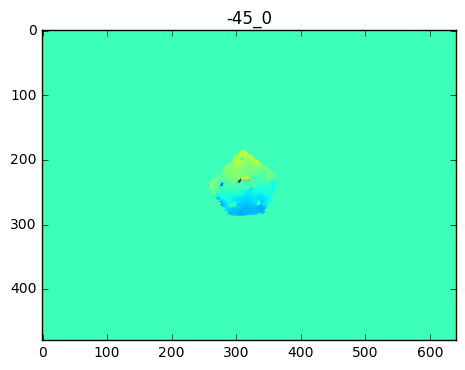

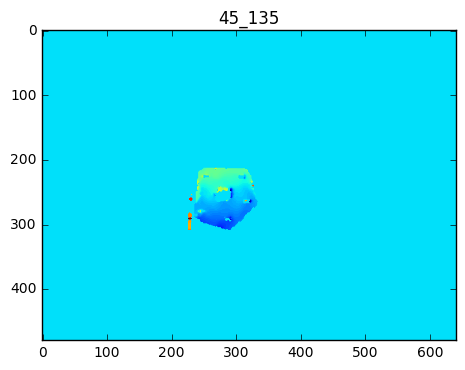

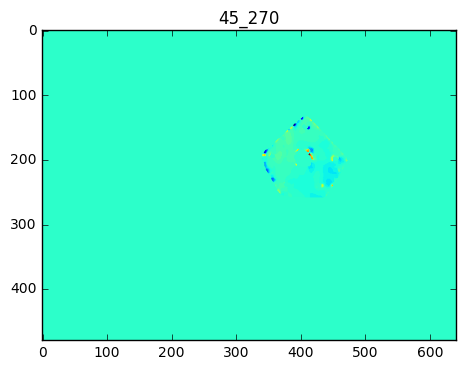

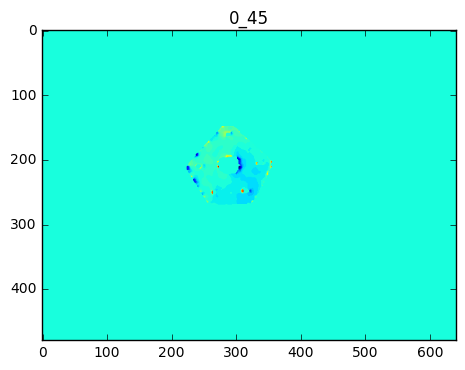

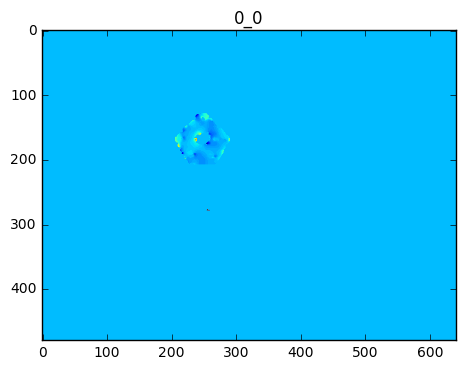

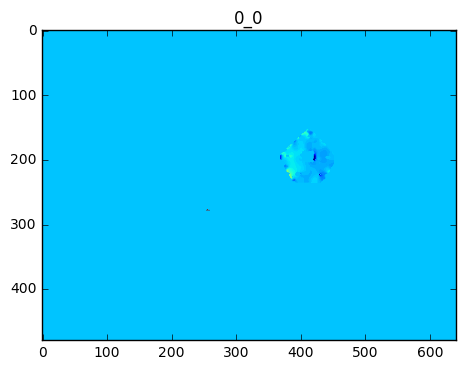

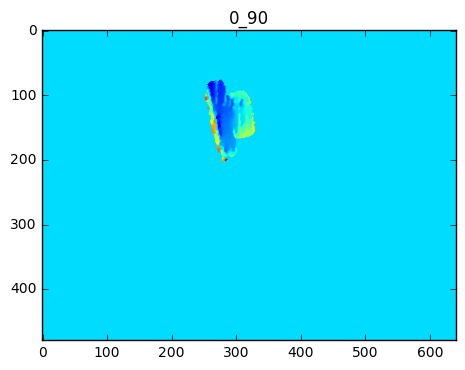

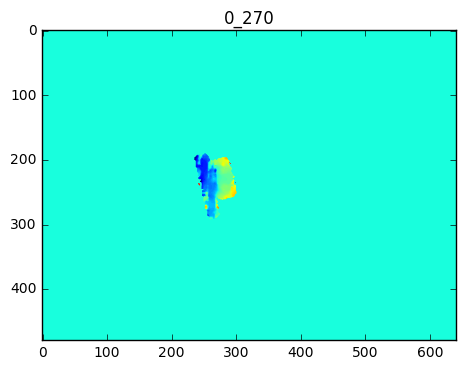

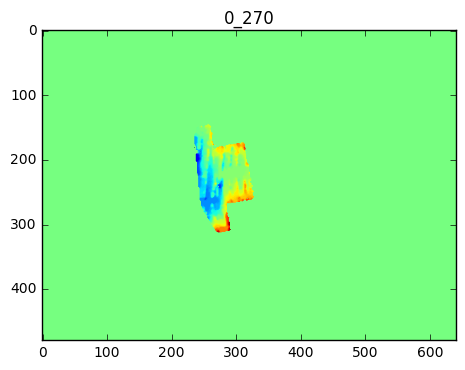

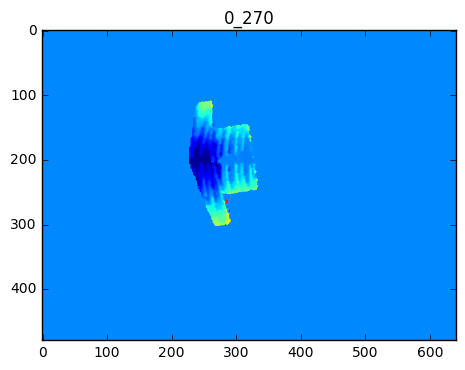

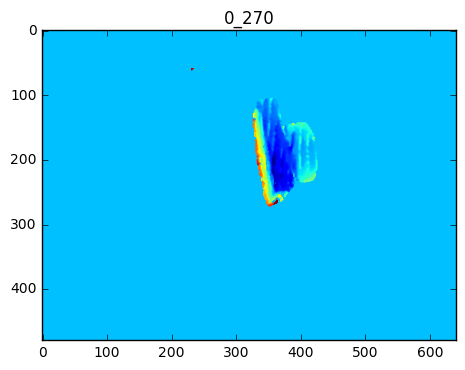

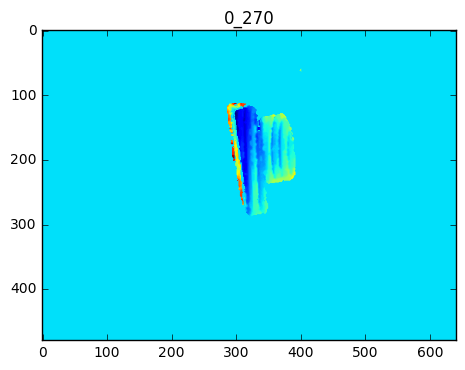

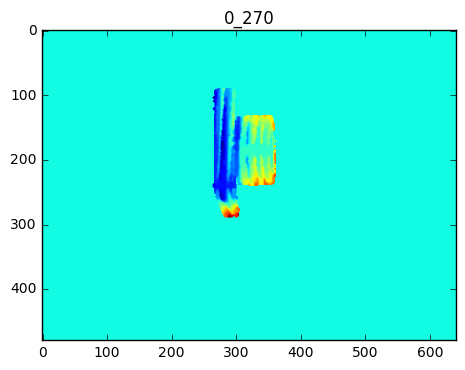

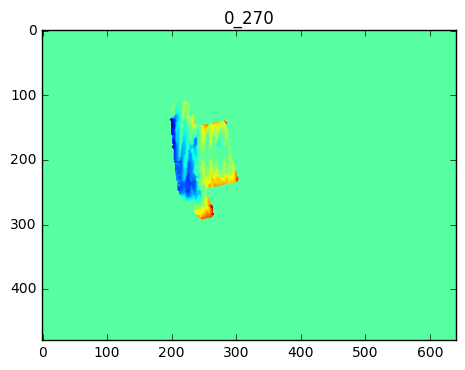

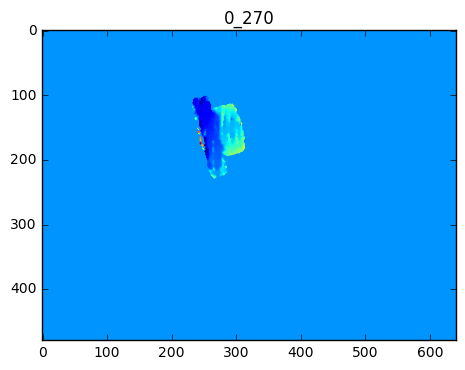

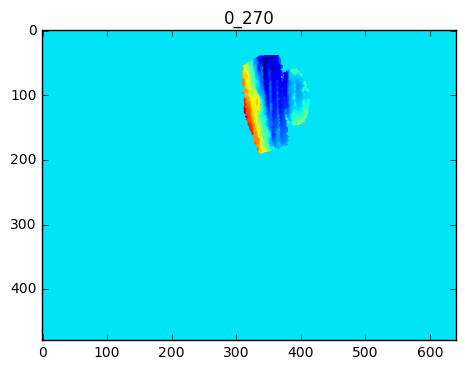

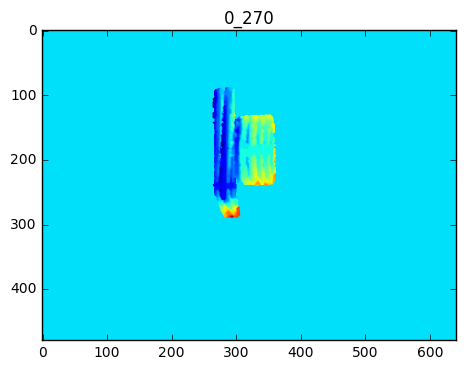

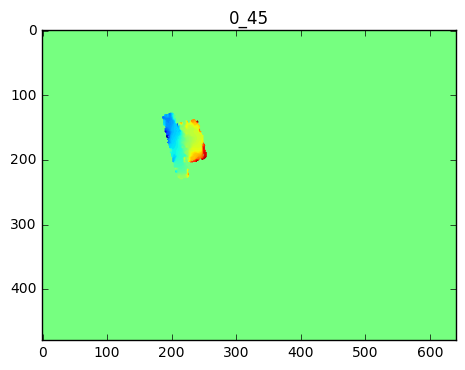

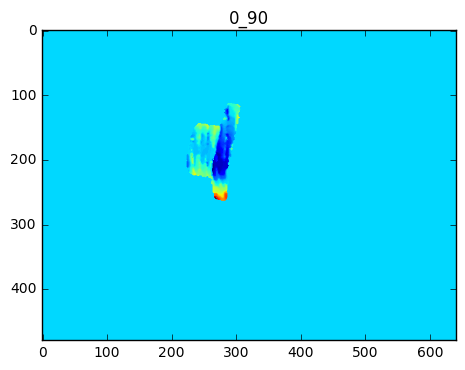

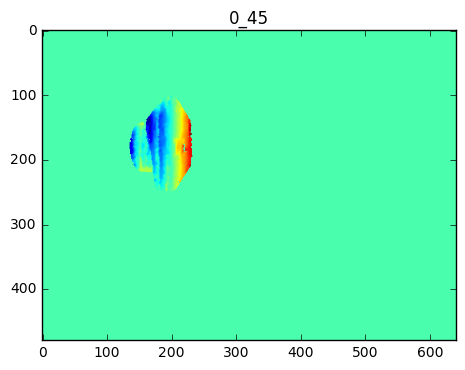

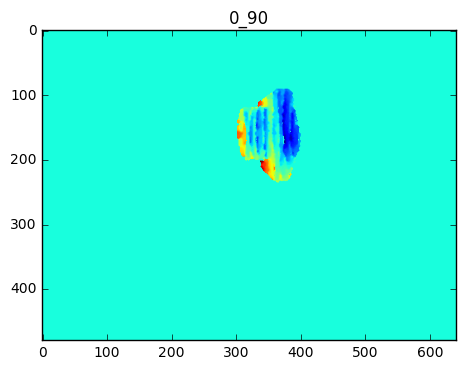

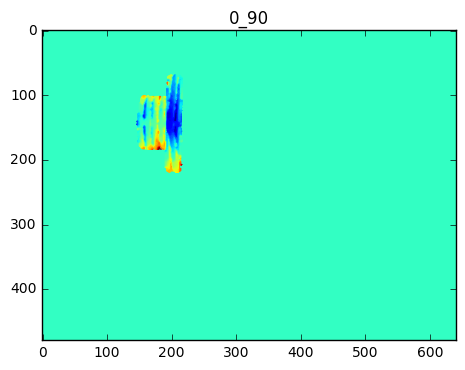

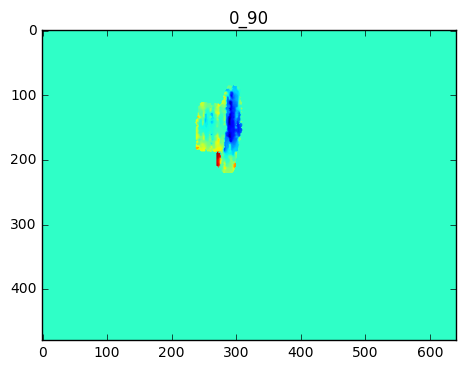

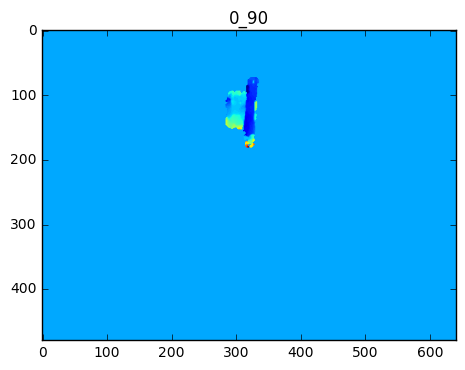

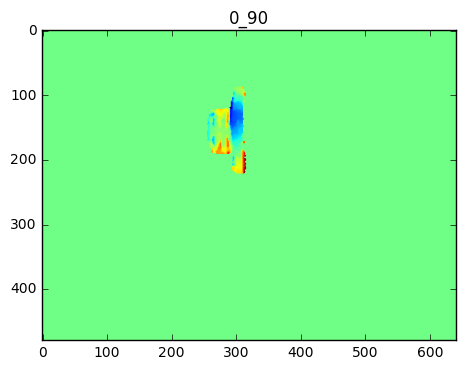

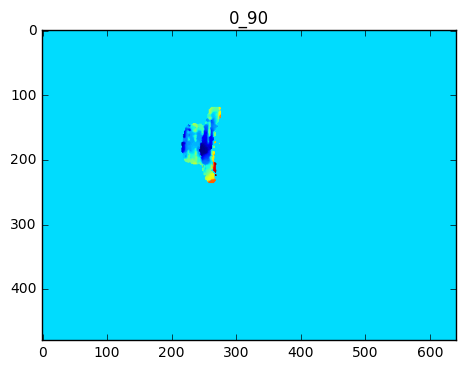

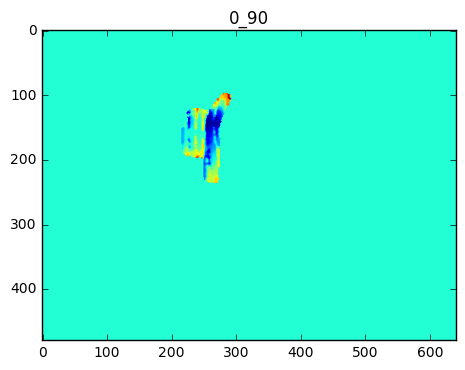

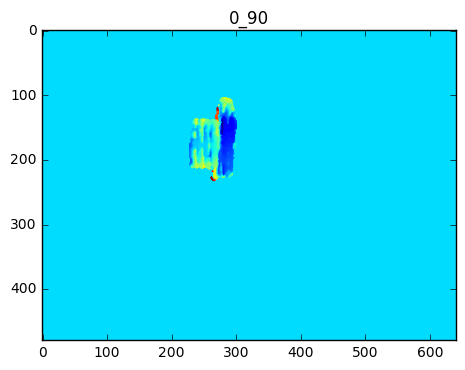

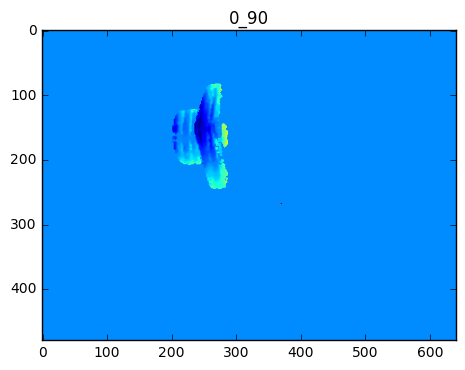

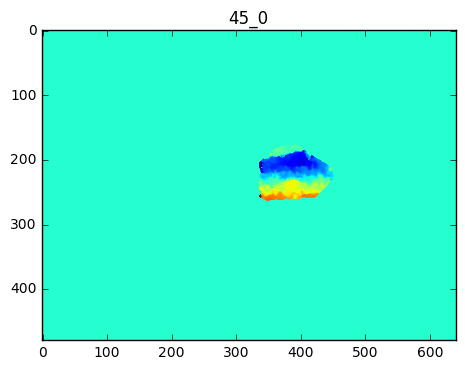

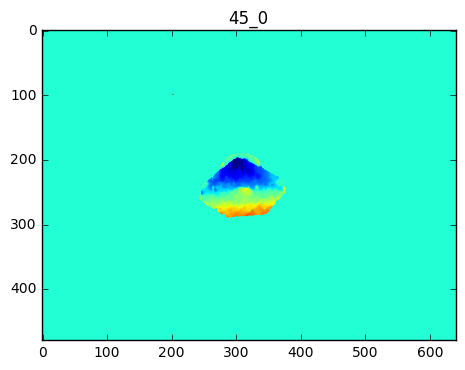

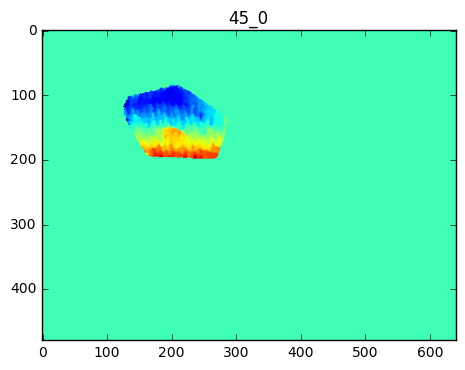

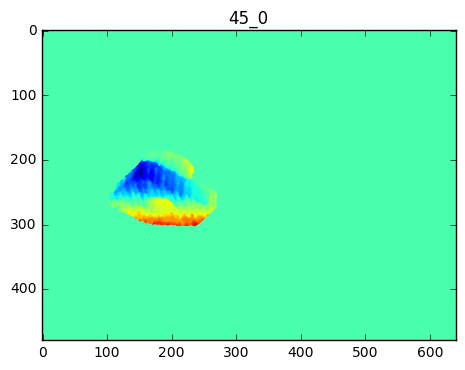

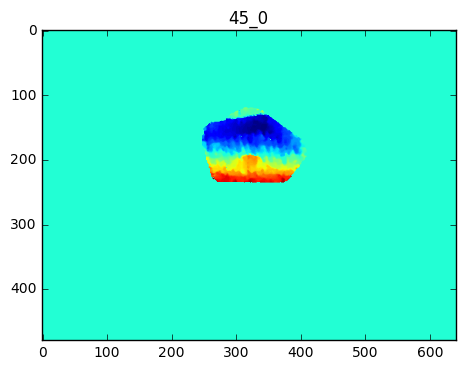

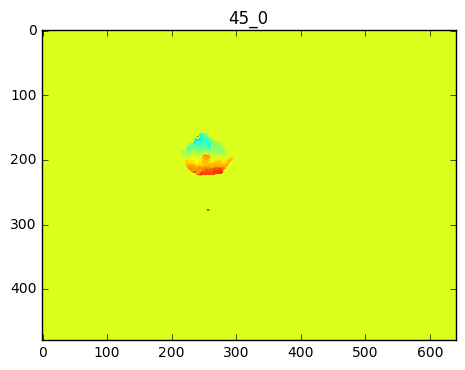

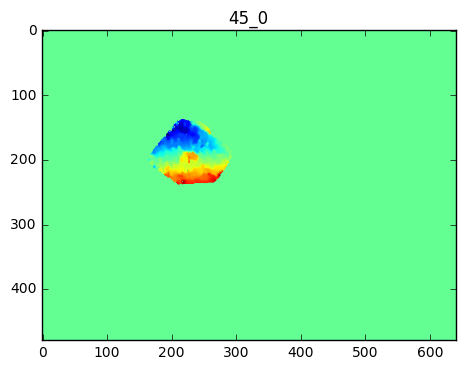

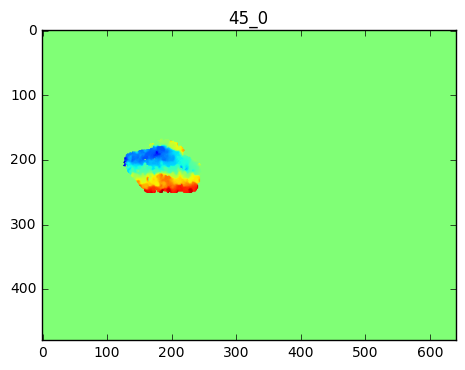

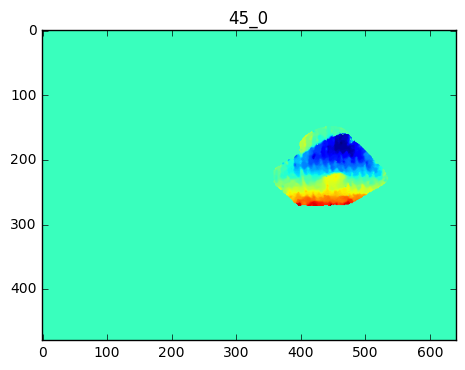

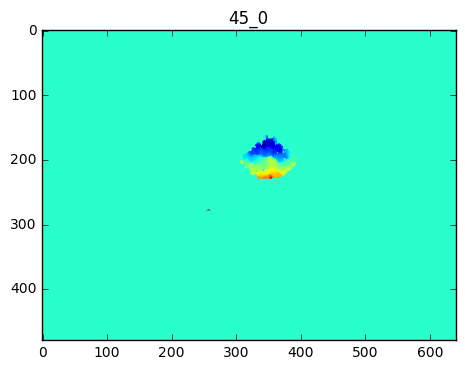

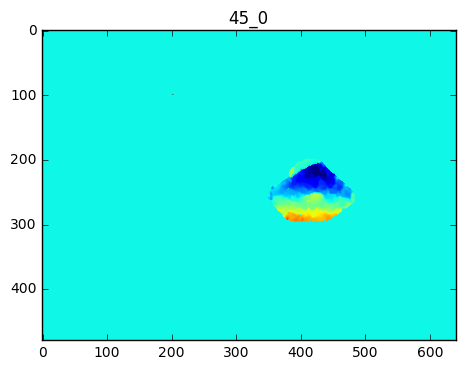

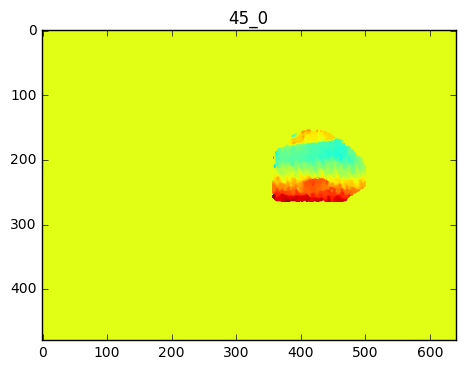

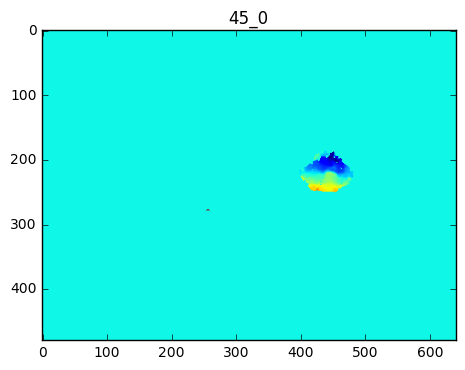

In [13]:
#test_model="./model/model_4class_14.pth"
test_model = best_model
dirname = './cropmap'
visual_best_model(test_model,dirname)

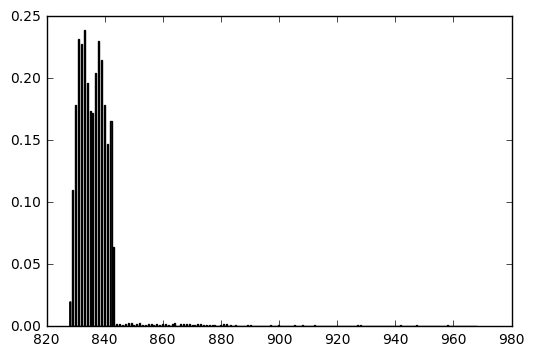

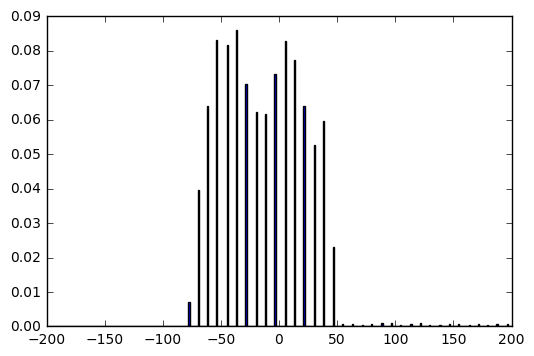

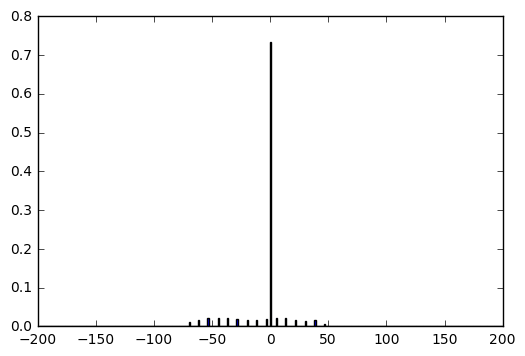

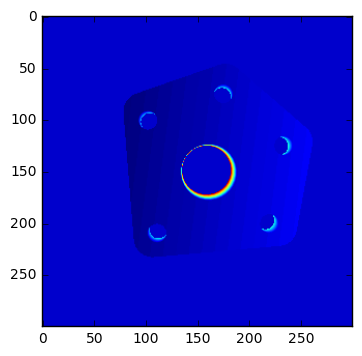

In [130]:
#dataFile = '/home/sjtu/gcj/data/depth_data/depth_2class/train/off_32_0_180/95_depth.mat'
dataFile = '/home/sjtu/gcj/data/depth_data/depth_2class/train/off_26_0_0/95_depth.mat'
data = scio.loadmat(dataFile)
#读取mat里的depth数据
depth = data['depth']
#归一化
depth=depth*300
depth=depth.astype(np.int)
depth_scale=depth[depth>0]
n,bins,patches=plt.hist(depth_scale,bins=400,normed=1)
plt.show()
depth=depth.astype(np.float)
depth_scale=depth[depth>0]
avrg=np.mean(depth_scale)
var=np.std(depth_scale)
index=depth==0
depth[index]=avrg
depth_scale=(depth-avrg)/var
depth_scale=depth_scale[100:400,150:450]

depth_show=depth_scale*100
depth_1=depth_show[depth_show!=0]
depth_2=depth_show.flatten()
n,bins,patches=plt.hist(depth_1,bins=400,normed=1,range=(-200,200))
plt.show()
n,bins,patches=plt.hist(depth_2,bins=400,normed=1,range=(-200,200))
plt.show()
plt.imshow(depth_scale)

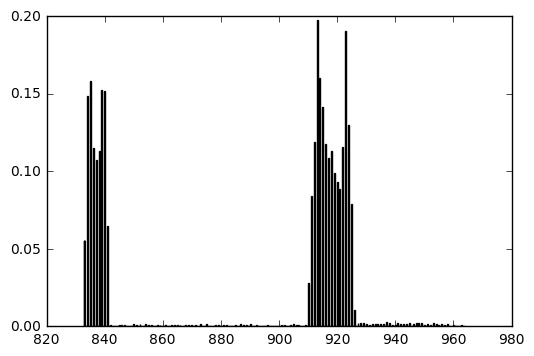

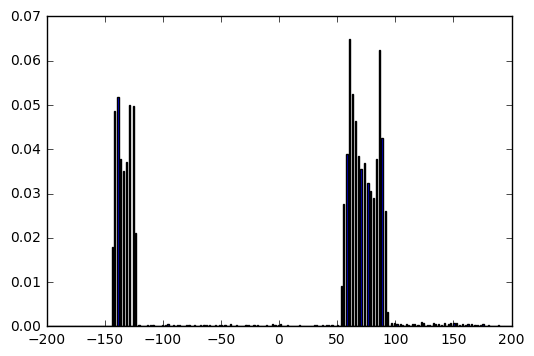

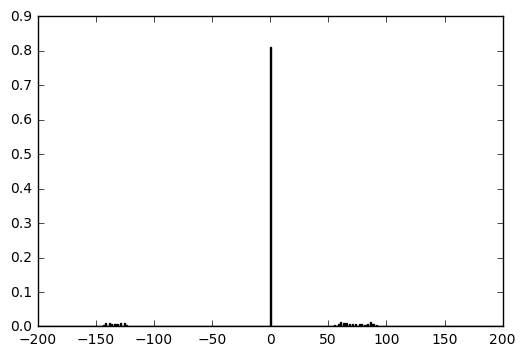

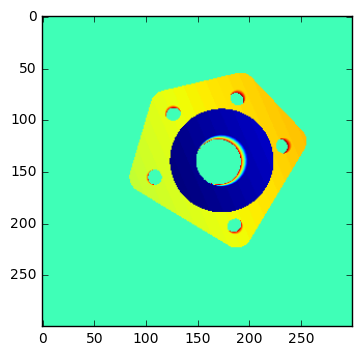

In [71]:
dataFile = '/home/sjtu/gcj/data/depth_data/depth_2class/train/off_32_0_180/95_depth.mat'
#dataFile = '/home/sjtu/gcj/data/depth_data/depth_2class/train/off_26_0_0/95_depth.mat'
data = scio.loadmat(dataFile)
#读取mat里的depth数据
depth = data['depth']
#归一化
depth=depth*300
depth=depth.astype(np.int)
depth_scale=depth[depth>0]
n,bins,patches=plt.hist(depth_scale,bins=400,normed=1)
plt.show()
depth=depth.astype(np.float)
depth_scale=depth[depth>0]
avrg=np.mean(depth_scale)
var=np.std(depth_scale)
index=depth==0
depth[index]=avrg
depth_scale=(depth-avrg)/var
depth_scale=depth_scale[100:400,150:450]

depth_show=depth_scale*100
depth_1=depth_show[depth_show!=0]
depth_2=depth_show.flatten()
n,bins,patches=plt.hist(depth_1,bins=400,normed=1,range=(-200,200))
plt.show()
n,bins,patches=plt.hist(depth_2,bins=400,normed=1,range=(-200,200))
plt.show()
plt.imshow(depth_scale)